# Trends

Interesting trends.

In [1]:
# init

import datetime
import os.path
import sys

sys.path.append(os.path.abspath(".."))

from matplotlib import pyplot
import numpy as np
import pandas as pd
import pandas.io.sql as psql
import seaborn as sns

from covid19stats.common import get_db_conn

conn = get_db_conn()

sns.set(style="darkgrid")

a4_dims = (11.7, 8.27)

## National Trends

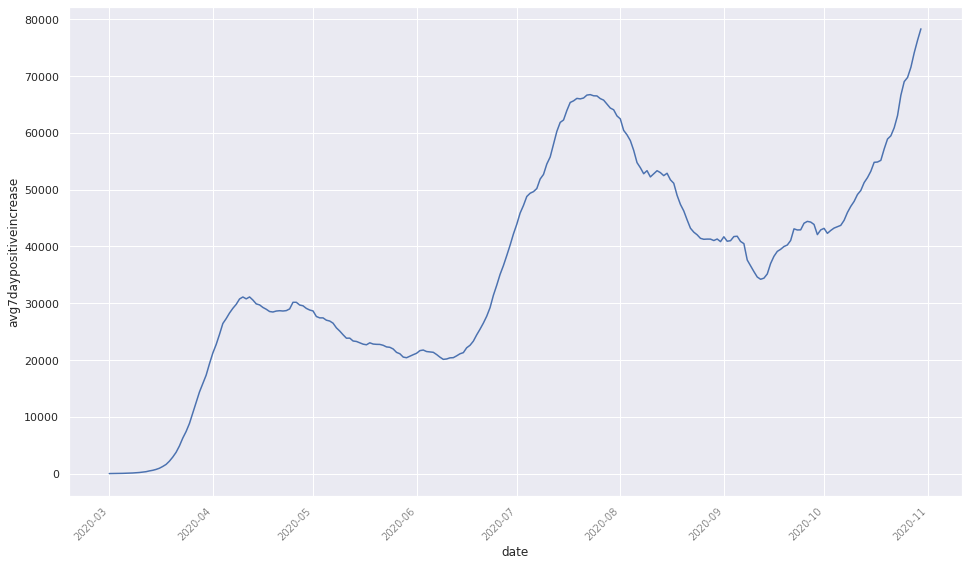

In [2]:
# plot for national trend in new cases

sql = """
    select 
        Date, Avg7DayPositiveIncrease
    from fact_nation n
    where date >= '2020-03-01'
    order by Date;
"""

df = psql.read_sql(sql, conn)

fig, ax = pyplot.subplots(1, 1, figsize=[16, 9])

chart = sns.lineplot(x="date", y="avg7daypositiveincrease", data=df, ax=ax)

pyplot.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='small'
);

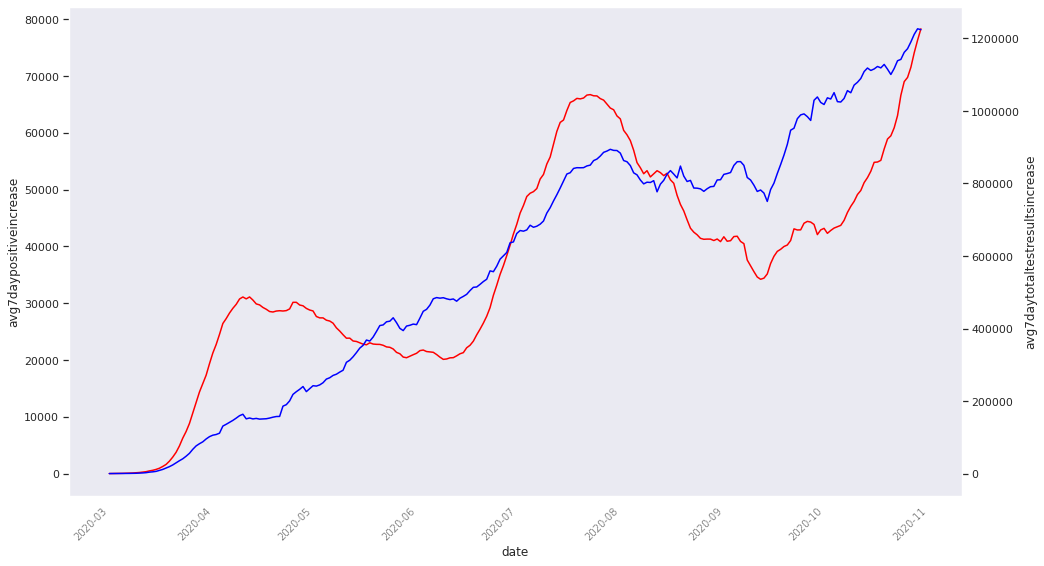

In [3]:
# compare total test results with new cases

sql = """
    select 
        Date, Avg7DayPositiveIncrease, Avg7DayTotalTestResultsIncrease
    from fact_nation n
    where date >= '2020-03-01'
    order by Date;
"""

df = psql.read_sql(sql, conn)

sns.set(style="dark")

fig, ax = pyplot.subplots(1, 1, figsize=[16, 9])

chart = sns.lineplot(x="date", y="avg7daypositiveincrease", data=df, ax=ax, color='red')

# for index, label in enumerate(ax.xaxis.get_ticklabels()):
#     if index % 7 != 0:
#         label.set_visible(False)

pyplot.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='small'
);

ax2 = ax.twinx()

chart = sns.lineplot(x="date", y="avg7daytotaltestresultsincrease", data=df, ax=ax2, color='blue')

# needed to avoid scientific notation on this y-axis
pyplot.ticklabel_format(style='plain', axis='y')

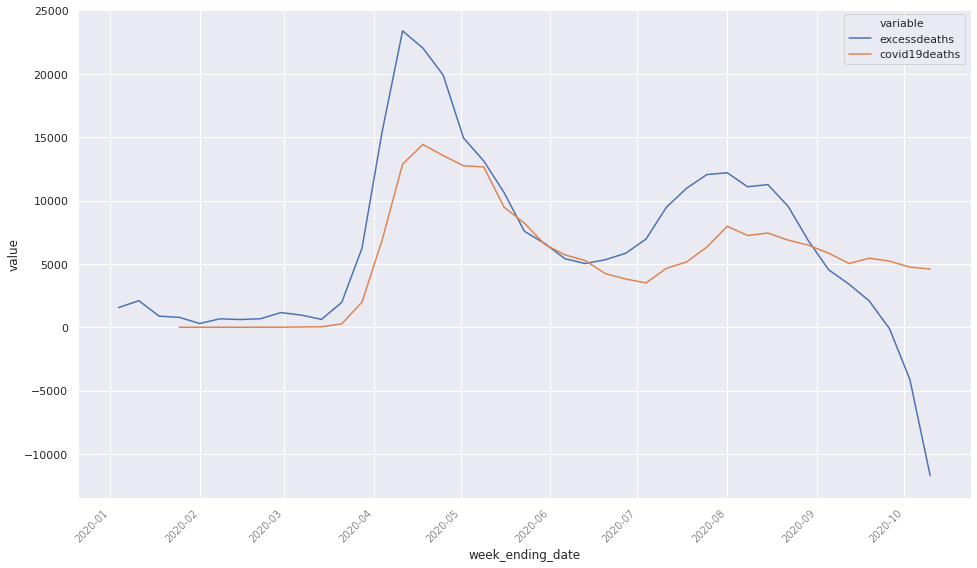

In [4]:
# compare reported covid-19 deaths with excess deaths

sql = """
    select 
        Week_Ending_Date, SUM(Excess) as ExcessDeaths, SUM(Covid19DeathsForWeek) as Covid19Deaths
    from fact_state_deaths
    group by Week_Ending_Date
    order by Week_Ending_Date;
"""

df = psql.read_sql(sql, conn)

df = pd.melt(df, id_vars=['week_ending_date'])

sns.set(style="darkgrid")

fig, ax = pyplot.subplots(1, 1, figsize=[16, 9])

chart = sns.lineplot(x="week_ending_date", y="value", hue="variable", data=df, ax=ax)

pyplot.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='small'
);

## State Trends

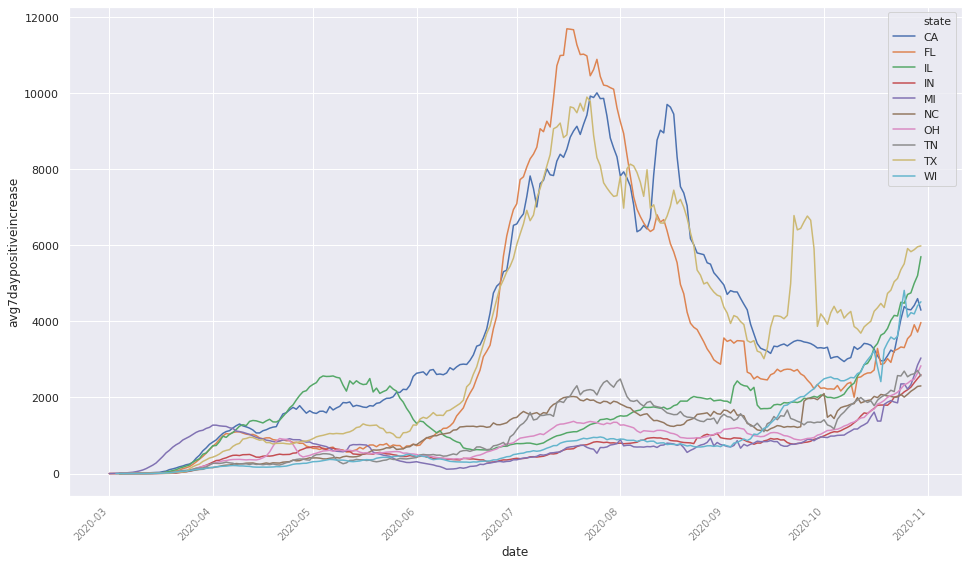

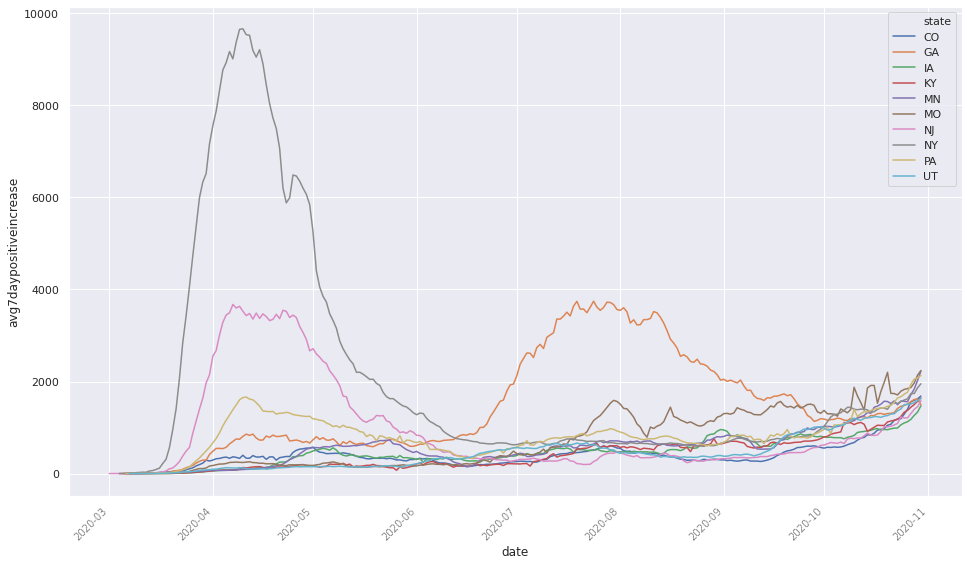

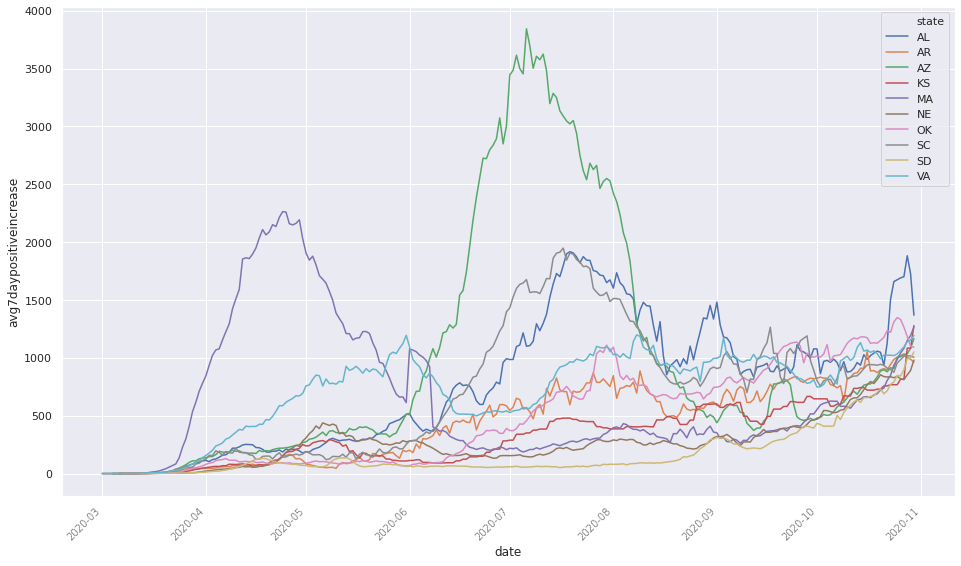

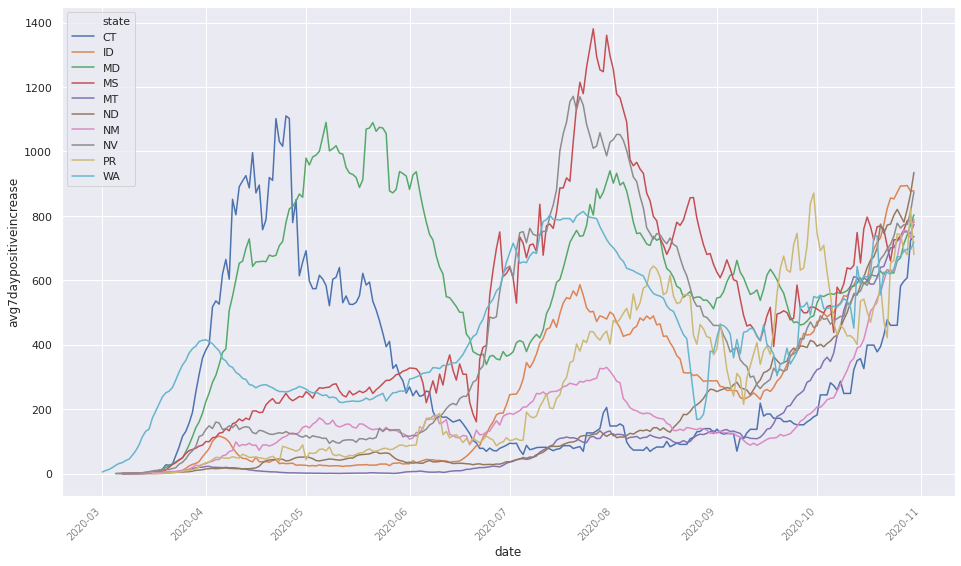

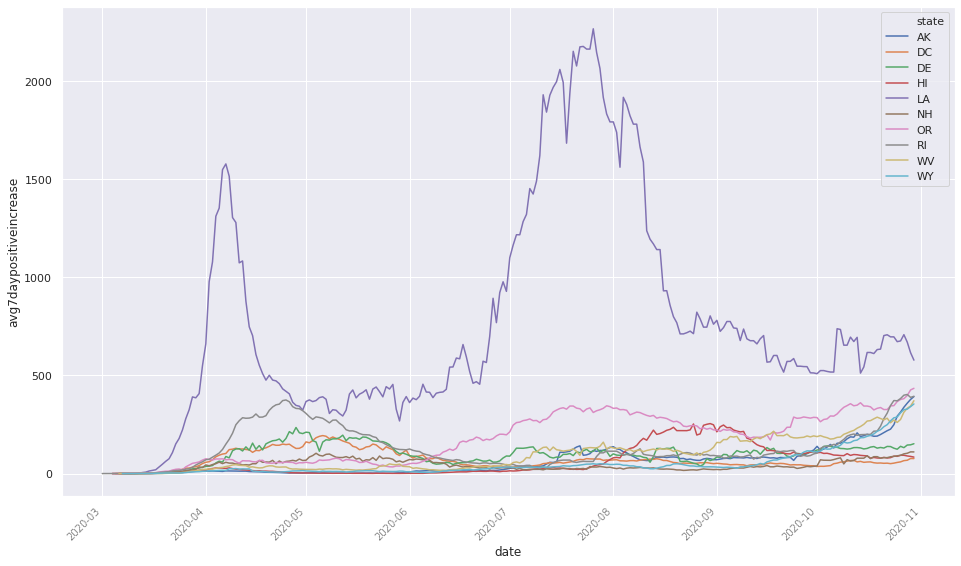

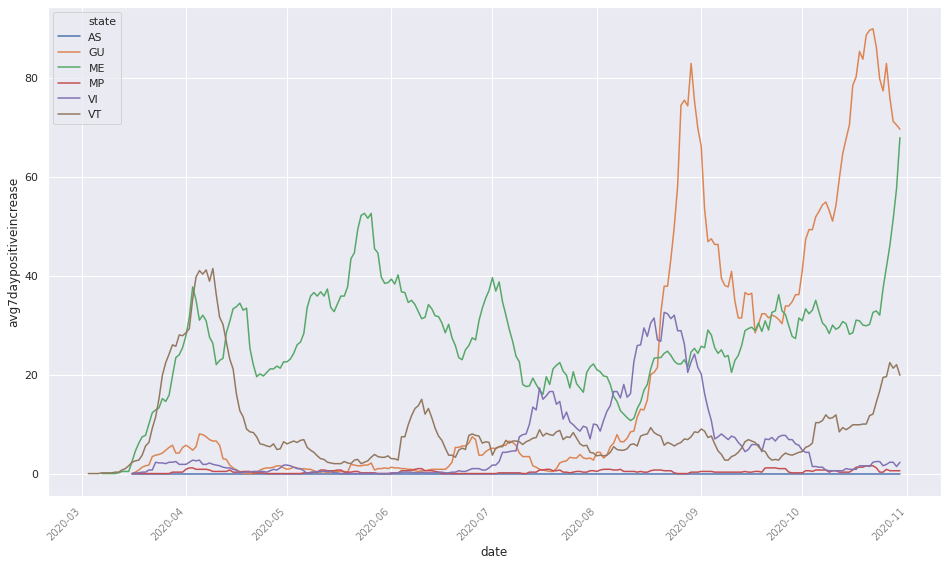

In [5]:
# show all states, split up by groups of 10, ordered by the largest most recent avg 7 day positive increase.

sql = """
   select 
        State, Avg7DayPositiveIncrease
    from fact_states
    where date = (select max(date) from fact_states)
    order by Avg7DayPositiveIncrease desc
"""

sorted = psql.read_sql(sql, conn)

sql = """
    select 
        Date, State, Avg7DayPositiveIncrease
    from fact_states
    where date >= '2020-03-01'
    order by state, Date
"""

df = psql.read_sql(sql, conn)

i = 0
chunksize = 10
while i < len(sorted):
    group = sorted[i:i+chunksize]['state'].tolist()

    subset = df[df['state'].isin(group)]

    fig, ax = pyplot.subplots(1, 1, figsize=[16, 9])

    chart = sns.lineplot(x="date", y="avg7daypositiveincrease", hue="state", data=subset, ax=ax)

    pyplot.xticks(
        rotation=45, 
        horizontalalignment='right',
        fontweight='light',
        fontsize='small'
    );    

    i = i + chunksize


In [6]:
# how current rates of infection compare to record highs.
# sorted by long how ago the record high was (top of chart = record high is more recent)

sql = """
WITH ranked AS ( 
    SELECT 
        *
        ,ROW_NUMBER() OVER (PARTITION BY state ORDER BY avg7daypositiveincrease DESC) as RN
    FROM fact_states
)
,recordhigh AS (
    SELECT
        state,
        date as RecordHighDate,
        avg7daypositiveincrease as RecordHigh
    FROM ranked
    WHERE RN = 1
)
,trend AS (
    SELECT
        s.state,
        s.avg7daypositiveincrease - earlier.avg7daypositiveincrease as ChangeLast2Weeks
    FROM fact_states s
    JOIN fact_states earlier
        ON s.state = earlier.state
        AND s.date = earlier.date + interval '14 days'
    WHERE
        s.date = (select max(date) from fact_states)
)
SELECT
    fact_states.date,
    fact_states.state,
    fact_states.avg7daypositiveincrease,
    recordhigh.RecordHighDate,
    recordhigh.RecordHigh,
    fact_states.avg7daypositiveincrease - recordhigh.RecordHigh AS FromHigh,
    CASE WHEN ChangeLast2Weeks > 0 THEN '+' ELSE '' END || CAST(ChangeLast2Weeks as varchar) AS ChangeLast2Weeks,
    CASE
        WHEN ChangeLast2Weeks > 0 THEN 'Trending Up'
        ELSE 'Trending Down'
    END as TrendLast2Weeks
FROM fact_states 
JOIN recordhigh
    on fact_states.state = recordhigh.state
JOIN trend
    on fact_states.state = trend.state
WHERE
    date = (select max(date) from fact_states)
ORDER BY
    recordhighdate desc
"""

df = psql.read_sql(sql, conn)

df

,date,state,avg7daypositiveincrease,recordhighdate,recordhigh,fromhigh,changelast2weeks,trendlast2weeks
0,2020-10-30,AK,392.428560,2020-10-30,392.428560,0.000000,+192.42856,Trending Up
1,2020-10-30,CO,1684.571400,2020-10-30,1684.571400,0.000000,+808.4285,Trending Up
2,2020-10-30,IA,1473.000000,2020-10-30,1473.000000,0.000000,+507.4286,Trending Up
3,2020-10-30,IL,5702.000000,2020-10-30,5702.000000,0.000000,+2387,Trending Up
4,2020-10-30,IN,2597.142800,2020-10-30,2597.142800,0.000000,+882.5714,Trending Up
5,2020-10-30,KS,1278.714200,2020-10-30,1278.714200,0.000000,+557.57135,Trending Up
6,2020-10-30,KY,1642.000000,2020-10-30,1642.000000,0.000000,+634.8571,Trending Up
7,2020-10-30,ME,67.857140,2020-10-30,67.857140,0.000000,+39.428566,Trending Up
8,2020-10-30,MI,3038.000000,2020-10-30,3038.000000,0.000000,+1423.2858,Trending Up
9,2020-10-30,MN,2228.857200,2020-10-30,2228.857200,0.000000,+788.28577,Trending Up
